In [538]:
import tarfile
import urllib
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer,make_column_selector,TransformedTargetRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.utils.validation import check_array,check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn import linear_model
import random as rd 
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel

The notebook is made for the purpose of getting familiar with skleran API, rather than analysing data and learning algorithms

In [5]:
def get_housing_data():
    the_path = Path('housing.tgz')
    if not the_path.is_file():
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url,the_path)
    with tarfile.open(the_path) as housing_tarball:
        housing_tarball.extractall(path = '.')
    return pd.read_csv('housing/housing.csv')


In [6]:
house_data = get_housing_data()

In [10]:
print(type(house_data))

<class 'pandas.core.frame.DataFrame'>


In [11]:
house_data.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<Axes: >

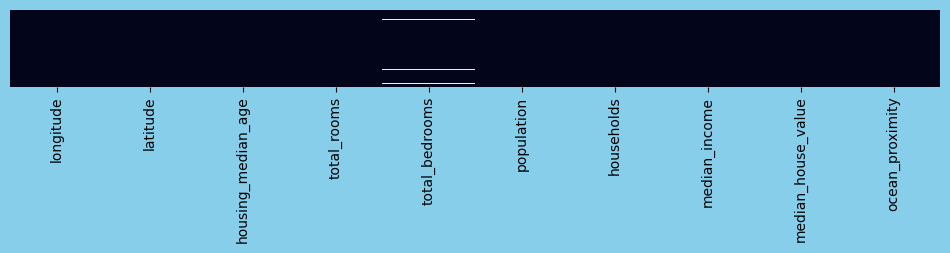

In [19]:
some_figure = plt.figure(figsize = (12,1),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
sns.heatmap(house_data.isnull(),annot = False,ax = some_ax,cbar = False,yticklabels = False)

In [23]:
house_data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

/tmp/ipykernel_4342/3085714317.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  house_data.hist(ax = hist_ax,bins = 50)


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

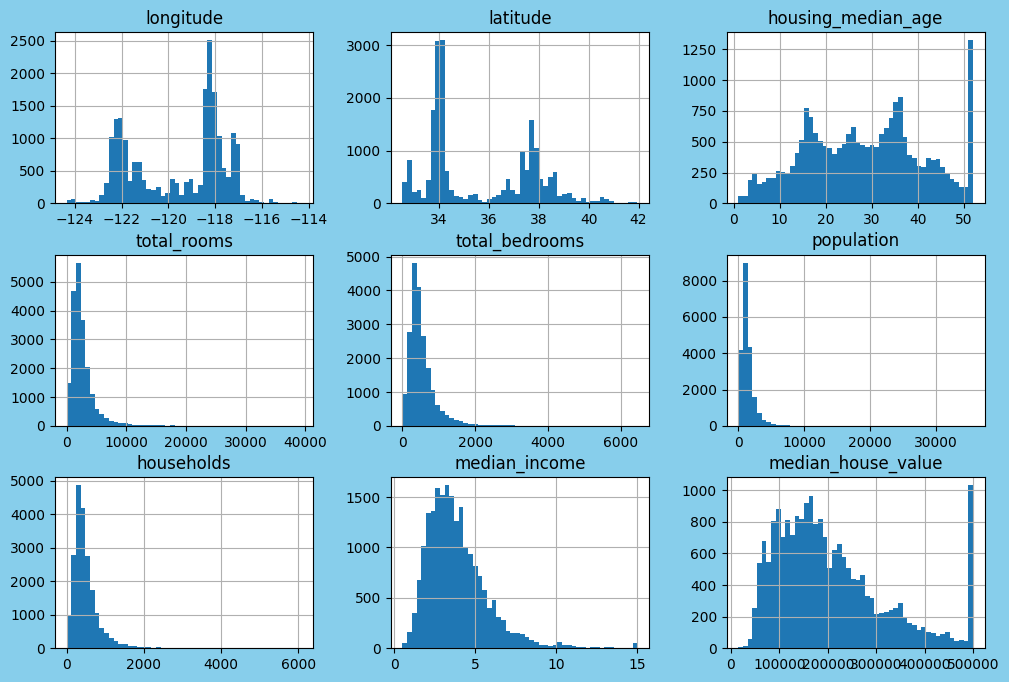

In [34]:
hist_figure = plt.figure(figsize = (12,8),facecolor = 'skyblue')
hist_ax = hist_figure.add_subplot()
house_data.hist(ax = hist_ax,bins = 50)

In [36]:
#I need this in order to make a representative split (stratified sampling)
house_data['income_cat'] = pd.cut(house_data['median_income'],bins = [0.,1.5,3.,4.5,6.,np.inf],labels = [1,2,3,4,5])

In [55]:
house_data['income_cat'].value_counts().sort_index()

income_cat
1     822
2    6581
3    7236
4    3639
5    2362
Name: count, dtype: int64

In [60]:
data_train,data_test = train_test_split(house_data,test_size = 0.2,stratify = house_data['income_cat'])

In [63]:
print(len(data_train))
print(len(data_test))

16512
4128


In [ ]:
#check whether stratifyed option was applied correctly
(data_test['income_cat'].value_counts()/len(data_test)).sort_values()

income_cat
1    0.039971
5    0.114341
4    0.176357
2    0.318798
3    0.350533
Name: count, dtype: float64

In [72]:
(house_data['income_cat'].value_counts()/len(house_data)).sort_values()

income_cat
1    0.039826
5    0.114438
4    0.176308
2    0.318847
3    0.350581
Name: count, dtype: float64

In [74]:
for one_set in (data_train,data_test):
    one_set.drop('income_cat',axis = 1,inplace = True)

In [ ]:
#Saving the datasets
# data_train.to_csv('Train.csv',index = False)
# data_test.to_csv('Test.csv',index = False)

In [499]:
data_train = pd.read_csv('Train.csv')
data_test = pd.read_csv('Test.csv')

In [500]:
print(len(data_train))
print(len(data_test))

16512
4128


In [501]:
explore_train_data = data_train.copy()

/tmp/ipykernel_5578/3229356299.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  explore_train_data.hist(ax = some_ax,bins = 50)


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

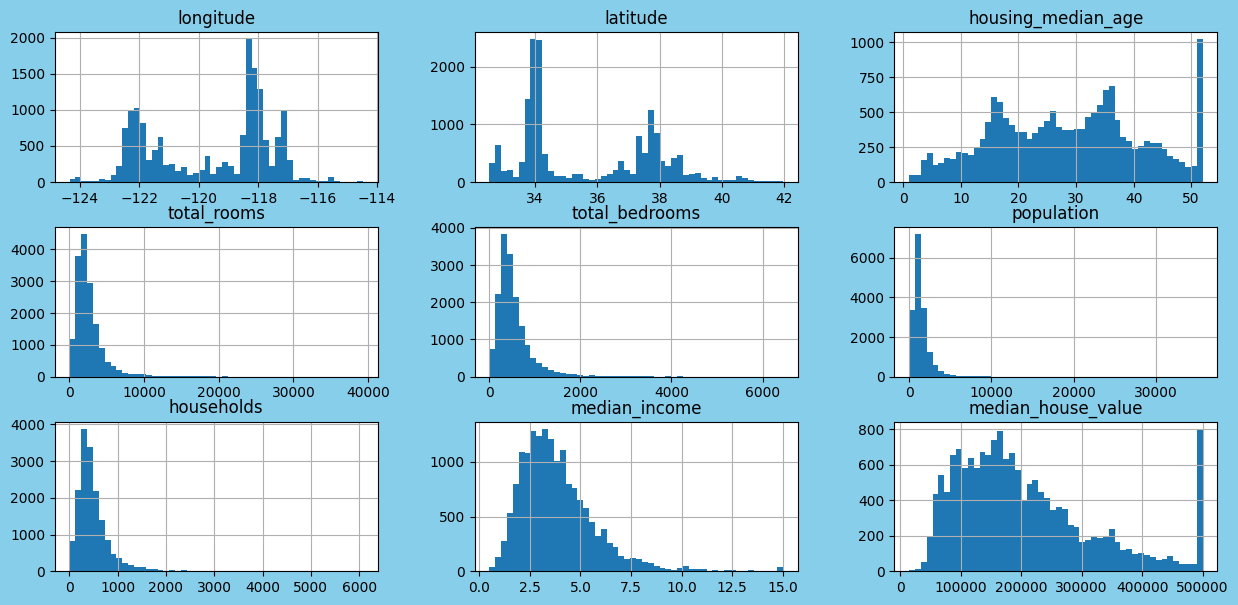

In [502]:
some_ax = plt.figure(figsize = (15,7),facecolor = 'skyblue')
explore_train_data.hist(ax = some_ax,bins = 50)

<Axes: >

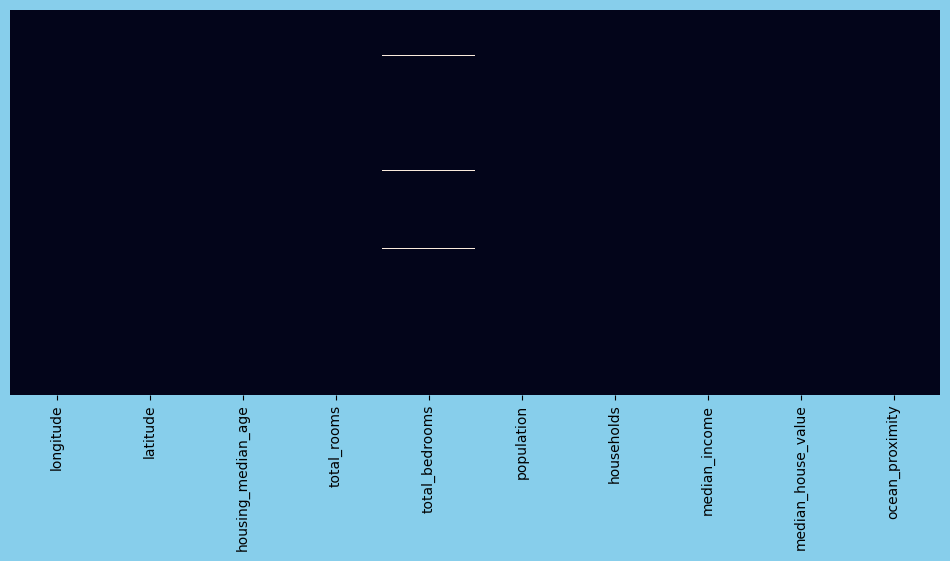

In [503]:
heat_figure = plt.figure(figsize = (12,5),facecolor = 'skyblue')
heat_ax = heat_figure.add_subplot()
sns.heatmap(explore_train_data.isnull(),ax = heat_ax,annot = False,cbar = False,yticklabels = False)

In [504]:
#make a baseline model
median_imputer = SimpleImputer(strategy = 'median')
median_imputer

SimpleImputer(strategy='median')

In [505]:
tot_bed_col = pd.DataFrame(median_imputer.fit_transform(explore_train_data[['total_bedrooms']]),index = explore_train_data.index,columns = explore_train_data[['total_bedrooms']].columns)

In [506]:
explore_train_data['total_bedrooms'] = tot_bed_col

In [507]:
explore_train_data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7314
INLAND        5262
NEAR OCEAN    2113
NEAR BAY      1818
ISLAND           5
Name: count, dtype: int64

In [528]:
col_trans = ColumnTransformer([
    ('SimpleImputer',SimpleImputer(strategy='median'),['total_bedrooms']),
    ('cats',OrdinalEncoder(),['ocean_proximity'])
],remainder = 'passthrough')
col_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('SimpleImputer',
                                 SimpleImputer(strategy='median'),
                                 ['total_bedrooms']),
                                ('cats', OrdinalEncoder(),
                                 ['ocean_proximity'])])

In [529]:
res = pd.DataFrame(col_trans.fit_transform(explore_train_data),index = explore_train_data.index,columns = col_trans.get_feature_names_out())
res

,SimpleImputer__total_bedrooms,cats__ocean_proximity,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__population,remainder__households,remainder__median_income,remainder__median_house_value
0,428.0,0.0,-122.02,37.28,25.0,3437.0,1198.0,411.0,9.3464,500001.0
1,332.0,1.0,-122.29,40.39,17.0,1682.0,887.0,316.0,1.8438,76400.0
2,218.0,1.0,-115.51,33.12,21.0,1024.0,890.0,232.0,2.1010,46700.0
3,621.0,1.0,-117.41,34.00,26.0,2372.0,1647.0,612.0,1.4719,88600.0
4,2596.0,0.0,-117.90,33.78,25.0,10336.0,7111.0,2419.0,3.3627,197900.0
...,...,...,...,...,...,...,...,...,...,...
16507,294.0,0.0,-118.34,34.16,46.0,1396.0,608.0,246.0,3.6920,244500.0
16508,666.0,1.0,-121.42,38.51,21.0,3249.0,2611.0,663.0,1.9423,87800.0
16509,265.0,0.0,-118.44,34.03,41.0,1164.0,561.0,251.0,4.2411,350900.0
16510,701.0,3.0,-122.25,37.81,52.0,2155.0,895.0,613.0,2.5795,350000.0


In [530]:
initial_pipeline = Pipeline([
    ('cat_trans',col_trans),
    ('lin_model',linear_model.LinearRegression())
])

In [545]:
initial_forest_pipeline = Pipeline([
    ('cat_trans',col_trans),
    ('lin_model',RandomForestRegressor())
])

In [532]:
initial_pipeline

Pipeline(steps=[('cat_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('SimpleImputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['total_bedrooms']),
                                                 ('cats', OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('lin_model', LinearRegression())])

In [546]:
X = explore_train_data.drop('median_house_value',axis = 1)
y = explore_train_data[['median_house_value']]

In [547]:
print(X.shape)
print(y.shape)

(16512, 9)
(16512, 1)


In [549]:
initial_forest_pipeline.fit(X,y)

/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('cat_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('SimpleImputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['total_bedrooms']),
                                                 ('cats', OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('lin_model', RandomForestRegressor())])

In [ ]:
#so we have that initial our score is very large
#this is for the linear model
metrics.root_mean_squared_error(y_pred = initial_pipeline.predict(X),y_true = y)

69283.07839558201

In [537]:
metrics.root_mean_squared_error(y_pred = initial_pipeline.predict(data_test.drop('median_house_value',axis = 1)),y_true = data_test[['median_house_value']])

71244.15955796978

In [550]:
#this is for the random forest model
metrics.root_mean_squared_error(y_pred = initial_forest_pipeline.predict(X),y_true = y)

18466.041351003965

In [551]:
metrics.root_mean_squared_error(y_pred = initial_forest_pipeline.predict(data_test.drop('median_house_value',axis = 1)),y_true = data_test[['median_house_value']])

50527.273346929986

In [37]:
print(explore_train_data['median_house_value'].max())
print(explore_train_data['median_house_value'].min())

500001.0
14999.0


In [46]:
#some random prediction
r = rd.randint(1,101)
xx = pd.DataFrame(X.iloc[r,:])
yy = pd.DataFrame(y.iloc[r,:])

In [47]:
initial_pipeline.predict(xx.T)

array([[277296.48776545]])

In [48]:
yy

,61
median_house_value,255600.0


In [49]:
initial_cross_score = cross_val_score(initial_pipeline,X,y,scoring = 'neg_root_mean_squared_error',cv = 30)

In [50]:
#baseline
initial_cross_score.mean() * (-1)

np.float64(69313.17922878024)

In [ ]:
#my goal is to do some analysis and see how it is going to affect the result

In [82]:
explore_train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.02,37.28,25.0,3437.0,428.0,1198.0,411.0,9.3464,500001.0,<1H OCEAN
1,-122.29,40.39,17.0,1682.0,332.0,887.0,316.0,1.8438,76400.0,INLAND
2,-115.51,33.12,21.0,1024.0,218.0,890.0,232.0,2.1010,46700.0,INLAND
3,-117.41,34.00,26.0,2372.0,621.0,1647.0,612.0,1.4719,88600.0,INLAND
4,-117.90,33.78,25.0,10336.0,2596.0,7111.0,2419.0,3.3627,197900.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
16507,-118.34,34.16,46.0,1396.0,294.0,608.0,246.0,3.6920,244500.0,<1H OCEAN
16508,-121.42,38.51,21.0,3249.0,666.0,2611.0,663.0,1.9423,87800.0,INLAND
16509,-118.44,34.03,41.0,1164.0,265.0,561.0,251.0,4.2411,350900.0,<1H OCEAN
16510,-122.25,37.81,52.0,2155.0,701.0,895.0,613.0,2.5795,350000.0,NEAR BAY


In [85]:
X = explore_train_data.drop('median_house_value',axis = 1)
y = explore_train_data[['median_house_value']]

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

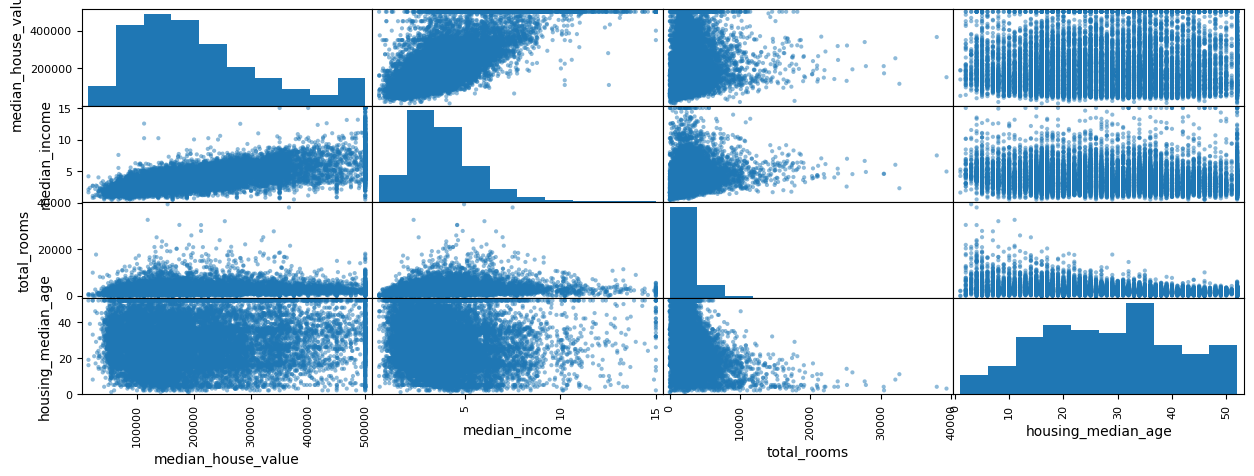

In [157]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(explore_train_data[attributes],figsize = (15,5))

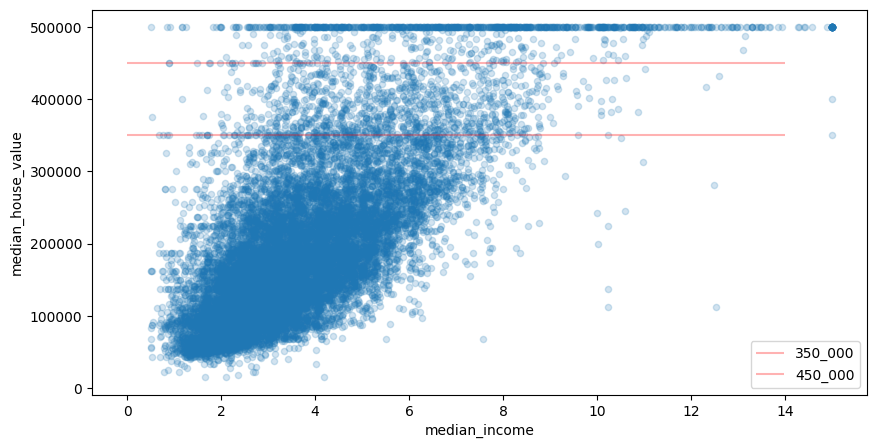

In [239]:
the_fig = plt.figure(figsize = (10,5))
the_ax = the_fig.add_subplot()
explore_train_data.plot(kind = 'scatter',x = 'median_income',y = 'median_house_value',alpha = 0.2,ax = the_ax)
the_ax.hlines(np.arange(350_000,351_000,1000),[0],[14],color = 'red',label = '350_000',alpha = 0.3)
the_ax.hlines(np.arange(450_000,451_000,1000),[0],[14],color = 'red',label = '450_000',alpha = 0.3)
the_ax.legend()

In [252]:
first_line_mask = (
    (explore_train_data['median_income']<3) & 
    (explore_train_data['median_house_value'] > 349_000) & 
    (explore_train_data['median_house_value']  < 351_000) 
)

second_line_mask = (
    (explore_train_data['median_income']<3) & 
    (explore_train_data['median_house_value'] > 449_000) & 
    (explore_train_data['median_house_value']  < 451_000) 
)

third_line_mask = (
    (explore_train_data['median_income']<3) & 
    (explore_train_data['median_house_value'] > 499_000) 
)

In [231]:
f1_data = explore_train_data.drop(index = explore_train_data[first_line_mask].index)

In [247]:
f2_data = f1_data.drop(index = explore_train_data[second_line_mask].index)

In [253]:
f3_data = f2_data.drop(index = explore_train_data[third_line_mask].index)

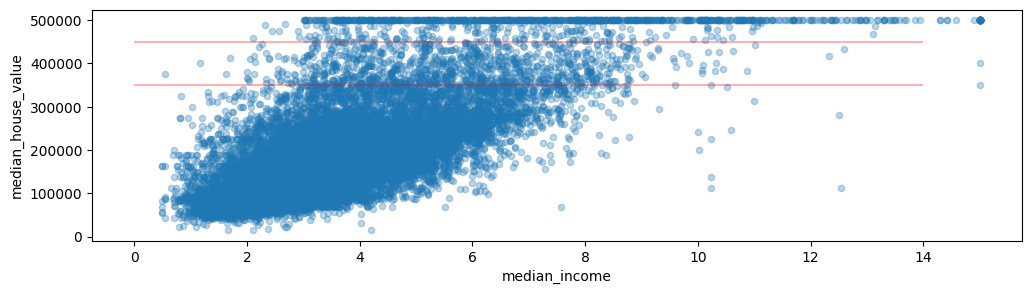

In [254]:
the_fig1 = plt.figure(figsize = (12,3))
the_ax1 = the_fig1.add_subplot()
f3_data.plot(kind = 'scatter',x = 'median_income',y = 'median_house_value',ax = the_ax1,alpha = 0.3)
the_ax1.hlines(np.arange(350_000,351_000,1000),[0],[14],color = 'red',label = '350_000',alpha = 0.3)
the_ax1.hlines(np.arange(450_000,451_000,1000),[0],[14],color = 'red',label = '450_000',alpha = 0.3)

In [256]:
print(explore_train_data.shape)
f3_data.shape

(16512, 10)


(16432, 10)

In [111]:
find_clusters = KMeans(n_clusters = 3)
find_clusters.fit(X[['longitude','latitude']])

KMeans(n_clusters=3)

In [112]:
points = find_clusters.cluster_centers_

In [113]:
points.T

array([[-117.09638375, -121.75810472, -118.36122688],
       [  33.31424779,   38.00026401,   34.20254071]])

In [114]:
points

array([[-117.09638375,   33.31424779],
       [-121.75810472,   38.00026401],
       [-118.36122688,   34.20254071]])

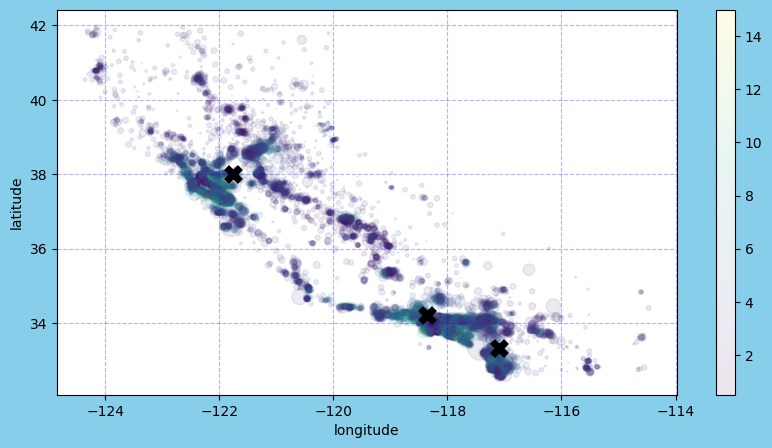

In [150]:
geo_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
geo_ax = geo_figure.add_subplot()
geo_ax.grid(linestyle = '--',c = 'blue',alpha = 0.3)

explore_train_data.plot(kind = 'scatter',
                        ax = geo_ax,
                        x = 'longitude',
                        y = 'latitude',
                        alpha = 0.1,
                        s = explore_train_data['population']/100,
                        c = explore_train_data['median_income'],colorbar = 'inferno',grid = True)

geo_ax.scatter(points.T[0,:],points.T[1,:],marker = 'x',s = 100,c = 'black',linewidths = 5)

In [291]:
class ClusterSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,n_clusters = 2,gamma = 0.05,random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self,X,y=None,sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters,random_state = self.random_state)
        self.kmeans_.fit(X,sample_weight = sample_weight)
        return self
    
    def transform(self,X):
        return rbf_kernel(X,self.kmeans_.cluster_centers_)

In [ ]:
#calculates the clusters and the distance to them for the long and lat
#it has two hyperparameters n_clusters and gamma

cluster_sim = ClusterSimilarity(n_clusters = 4)
cluster_sim.fit_transform(X[['longitude','latitude']])

array([[7.02841775e-01, 2.61011576e-06, 3.79396241e-02, 3.48765678e-10],
       [7.05252358e-02, 2.75904218e-13, 4.48243434e-06, 1.33568243e-18],
       [4.24190075e-15, 2.11839903e-02, 1.42364003e-06, 3.53820827e-01],
       ...,
       [5.35769141e-07, 9.55057403e-01, 4.71458735e-02, 2.04930503e-01],
       [9.07325780e-01, 1.60584555e-07, 1.03519280e-02, 9.79894641e-12],
       [3.03502996e-08, 9.55469201e-01, 1.29849467e-02, 4.70855571e-01]],
      shape=(16512, 4))

<Axes: >

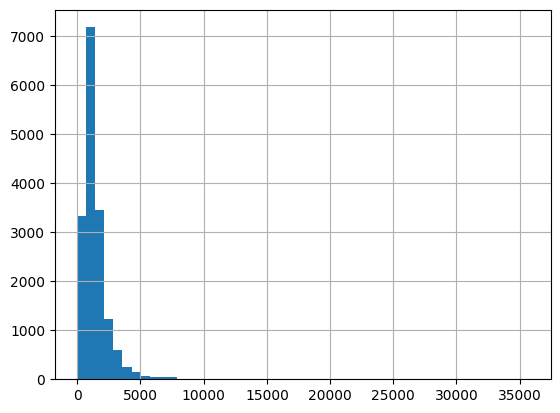

In [301]:
pop = f3_data['population']
pop.hist(bins = 50)

In [302]:
to_log = FunctionTransformer(func = np.log,inverse_func = np.exp)
to_log

FunctionTransformer(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>)

<Axes: >

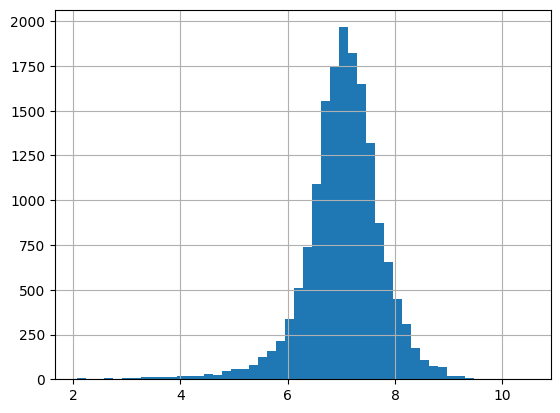

In [305]:
to_log.fit_transform(pop).hist(bins = 50)

In [315]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy = 'median'),
    FunctionTransformer(np.log,feature_names_out = 'one-to-one'),
    StandardScaler()
)
log_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('functiontransformer',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<ufunc 'log'>)),
                ('standardscaler', StandardScaler())])

In [325]:
def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio,feature_names_out=ratio_name),
        StandardScaler()
    )
ratio_pipeline()

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('functiontransformer',
                 FunctionTransformer(feature_names_out=<function ratio_name at 0x7ab2b0b78400>,
                                     func=<function column_ratio at 0x7ab2b0b7a020>)),
                ('standardscaler', StandardScaler())])

In [326]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy = 'median'),StandardScaler())
default_num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [443]:
cluster_sim = ClusterSimilarity(n_clusters=2,gamma = 0.05,random_state = 42)
cluster_sim

ClusterSimilarity(random_state=42)

In [444]:
def hot_and_drop(X):
    X = OneHotEncoder().fit_transform(X).toarray()
    return X[:,1:]

cat_pipeline = FunctionTransformer(hot_and_drop,feature_names_out='one-to-one')

In [445]:
Xf3 = f3_data.drop('median_house_value',axis = 1)
yf3 = f3_data[['median_house_value']]
print(Xf3.shape,yf3.shape)

(16432, 9) (16432, 1)


In [446]:
preprocessing = ColumnTransformer([
    ('bedrooms',ratio_pipeline(),['total_bedrooms','total_rooms']),
    ('room_per_house',ratio_pipeline(),['total_rooms','households']),
    ('people_per_house',ratio_pipeline(),['population','households']),
    ('log',log_pipeline,['total_bedrooms','total_rooms','population',
                         'households','median_income']),
    ('geo',cluster_sim,['longitude','latitude']),
    ('cat',cat_pipeline,make_column_selector(dtype_include = object))
],remainder = default_num_pipeline)

In [450]:
prep_res1 = preprocessing.fit_transform(Xf3)

In [454]:
print(prep_res1.shape)

(16432, 15)


In [456]:
prep_res2 = preprocessing.fit_transform(X_test)

In [464]:
X_test['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     1822
INLAND        1289
NEAR OCEAN     545
NEAR BAY       472
Name: count, dtype: int64

In [466]:
Xf3['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7267
INLAND        5260
NEAR OCEAN    2104
NEAR BAY      1798
ISLAND           3
Name: count, dtype: int64

In [448]:
preprocessing.fit_transform(X_test).shape

(4128, 14)

In [408]:
my_lin_model = TransformedTargetRegressor(linear_model.LinearRegression(),transformer=StandardScaler())
my_lin_model

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

In [435]:
pipe_model = make_pipeline(preprocessing,TransformedTargetRegressor(linear_model.LinearRegression(),transformer=StandardScaler()))

In [540]:
pipe_forest = make_pipeline(preprocessing,TransformedTargetRegressor(RandomForestRegressor(),transformer=StandardScaler()))
pipe_forest

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ab...
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function hot_and_drop at 0x7ab2a4b30f40>),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ab2a54de660>)])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                            transformer=StandardScaler()))])

In [436]:
pipe_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ab...
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function hot_and_drop at 0x7ab2a4f36e80>),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ab2a54ddb80>)])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=StandardScaler()))])

In [437]:
pipe_model.fit(Xf3,yf3)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ab...
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function hot_and_drop at 0x7ab2a4f36e80>),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ab2a54ddb80>)])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=StandardScaler()))])

In [493]:
metrics.root_mean_squared_error(y_pred = pipe_model.predict(Xf3),y_true = yf3)

68964.2727728933

In [541]:
pipe_forest.fit(Xf3,yf3)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ab...
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function hot_and_drop at 0x7ab2a4b30f40>),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ab2a54de660>)])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                            transformer=StandardScaler()))])

In [542]:
metrics.root_mean_squared_error(y_pred = pipe_forest.predict(Xf3),y_true = yf3)

17447.256485088314

In [ ]:
#this happens because some categorical features do not get into the necessary splits
#and therefore the OneHotEncoding do not create the necessary number of columns
pipe_cross = cross_val_score(pipe_model,Xf3,yf3,scoring = 'neg_root_mean_squared_error')

/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/utils/_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
      

In [487]:
one_row = Xf3[Xf3['ocean_proximity'] == 'ISLAND'].iloc[[0]]
one_row.index = ['F']

In [488]:
one_row

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
F,-118.32,33.33,52.0,2127.0,512.0,733.0,288.0,3.3906,ISLAND


In [496]:
y_one_row = yf3[Xf3['ocean_proximity'] == 'ISLAND'].iloc[[0]]
y_one_row

,median_house_value
6689,300000.0


In [497]:
X_test = data_test.drop('median_house_value',axis= 1)
X_test = pd.concat([X_test,one_row],ignore_index = False)

y_test = data_test[['median_house_value']]
y_test = pd.concat([y_test,y_one_row],ignore_index = False)
print(X_test.shape,y_test.shape)

(4129, 9) (4129, 1)


In [498]:
metrics.root_mean_squared_error(y_pred = pipe_model.predict(X_test),y_true = y_test)

73136.45922993313

In [ ]:
#with random forest regressor is a little bit better
metrics.root_mean_squared_error(y_pred = pipe_forest.predict(X_test),y_true = y_test)

51713.65346725288